In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)

# Make project modules importable (utils, analysis, etc.)
sys.path.append("..")

from analysis.utils.connection import get_conn

print("Imports successful.")

Imports successful.


In [7]:
def load_fact_sales():
    conn = get_conn()
    
    query = """
    SELECT
        CustomerKey,
        OrderNumber,
        OrderDateKey,
        TotalSalesUSD
    FROM dbo.FactSales
    ORDER BY OrderDateKey
    """
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    # Convert YYYYMMDD integer → datetime
    df["OrderDate"] = pd.to_datetime(df["OrderDateKey"].astype(str), format="%Y%m%d")
    
    return df


fact_sales = load_fact_sales()

print("FactSales shape:", fact_sales.shape)
display(fact_sales.head())
display(fact_sales.tail())

C:\Users\athil\AppData\Local\Temp\ipykernel_8040\3383092867.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


FactSales shape: (62884, 5)


,CustomerKey,OrderNumber,OrderDateKey,TotalSalesUSD,OrderDate
0,265598,366000,20160101,68.00,2016-01-01
1,1269051,366001,20160101,854.00,2016-01-01
2,1269051,366001,20160101,665.94,2016-01-01
3,266019,366002,20160101,2254.00,2016-01-01
4,266019,366002,20160101,326.00,2016-01-01


,CustomerKey,OrderNumber,OrderDateKey,TotalSalesUSD,OrderDate
62879,1216913,2243030,20210220,417.00,2021-02-20
62880,511229,2243031,20210220,480.00,2021-02-20
62881,331277,2243032,20210220,219.98,2021-02-20
62882,331277,2243032,20210220,140.26,2021-02-20
62883,331277,2243032,20210220,4753.00,2021-02-20


In [8]:
snapshot_date = fact_sales["OrderDate"].max() + pd.Timedelta(days=1)

print("RFM Snapshot Date:", snapshot_date)

RFM Snapshot Date: 2021-02-21 00:00:00


In [9]:
rfm_raw = (
    fact_sales
    .groupby("CustomerKey")
    .agg(
        Recency=("OrderDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("OrderNumber", "nunique"),
        Monetary=("TotalSalesUSD", "sum")
    )
    .reset_index()
)

print("RFM raw shape:", rfm_raw.shape)
display(rfm_raw.head())

RFM raw shape: (11887, 4)


,CustomerKey,Recency,Frequency,Monetary
0,301,468,1,592.00
1,325,414,3,5787.67
2,554,444,2,951.71
3,1042,1083,1,1124.91
4,1314,1160,1,4254.88


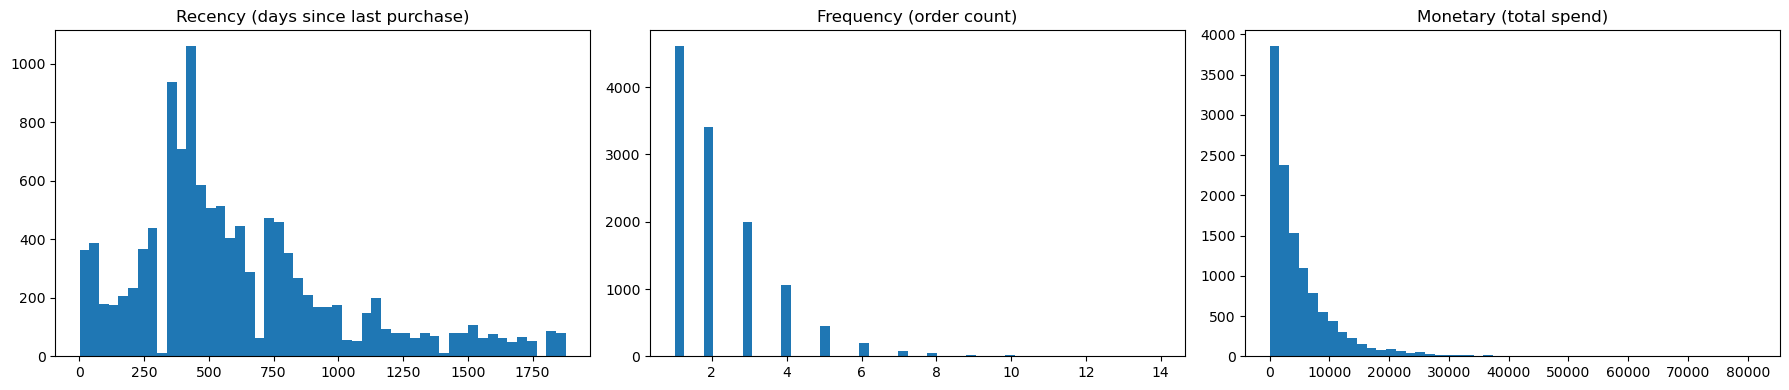

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(rfm_raw["Recency"], bins=50)
axes[0].set_title("Recency (days since last purchase)")

axes[1].hist(rfm_raw["Frequency"], bins=50)
axes[1].set_title("Frequency (order count)")

axes[2].hist(rfm_raw["Monetary"], bins=50)
axes[2].set_title("Monetary (total spend)")

plt.tight_layout()
plt.show()

In [15]:
rfm = rfm_raw.copy()

# Recency: lower is better → reverse labels
rfm["R_Score"] = pd.qcut(
    rfm["Recency"], 
    q=5, 
    labels=[5, 4, 3, 2, 1]
)

# Frequency: higher is better
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"),
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# Monetary: higher is better
rfm["M_Score"] = pd.qcut(
    rfm["Monetary"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

rfm[["R_Score", "F_Score", "M_Score"]] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int)

display(rfm.head())

,CustomerKey,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,301,468,1,592.00,3,1,1
1,325,414,3,5787.67,4,4,4
2,554,444,2,951.71,3,2,2
3,1042,1083,1,1124.91,1,1,2
4,1314,1160,1,4254.88,1,1,4


In [17]:
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm["RFM_Sum"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)

display(rfm[["CustomerKey", "Recency", "Frequency", "Monetary", "RFM_Score", "RFM_Sum"]].head())

,CustomerKey,Recency,Frequency,Monetary,RFM_Score,RFM_Sum
0,301,468,1,592.00,311,5
1,325,414,3,5787.67,444,12
2,554,444,2,951.71,322,7
3,1042,1083,1,1124.91,112,4
4,1314,1160,1,4254.88,114,6


In [19]:
def rfm_segment(row):
    if row["RFM_Sum"] >= 13:
        return "Champions"
    elif row["RFM_Sum"] >= 10:
        return "Loyal"
    elif row["RFM_Sum"] >= 8:
        return "Potential Loyalist"
    elif row["RFM_Sum"] >= 6:
        return "At Risk"
    else:
        return "Lost"

rfm["Segment"] = rfm.apply(rfm_segment, axis=1)

rfm["Segment"].value_counts()

Segment
Loyal                 3120
Potential Loyalist    2359
Champions             2162
At Risk               2135
Lost                  2111
Name: count, dtype: int64

In [21]:
def load_customer_insight():
    conn = get_conn()
    
    query = """
    SELECT
        CustomerKey,
        Gender,
        Country,
        State,
        Continent,
        Age,
        AgeGroup
    FROM dbo.vw_CustomerInsights
    """
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    return df


customer_insight = load_customer_insight()

print("Customer insight shape:", customer_insight.shape)
display(customer_insight.head())

Customer insight shape: (15266, 7)


C:\Users\athil\AppData\Local\Temp\ipykernel_8040\277023655.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,CustomerKey,Gender,Country,State,Continent,Age,AgeGroup
0,301,Female,Australia,South Australia,Australia,86,55+
1,325,Female,Australia,Western Australia,Australia,46,45-54
2,554,Female,Australia,Victoria,Australia,78,55+
3,786,Male,Australia,South Australia,Australia,68,55+
4,1042,Male,Australia,Victoria,Australia,60,55+


In [23]:
rfm_enriched = rfm.merge(
    customer_insight,
    on="CustomerKey",
    how="left"
)

print("RFM enriched shape:", rfm_enriched.shape)
display(rfm_enriched.head())

RFM enriched shape: (11887, 16)


,CustomerKey,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum,Segment,Gender,Country,State,Continent,Age,AgeGroup
0,301,468,1,592.00,3,1,1,311,5,Lost,Female,Australia,South Australia,Australia,86,55+
1,325,414,3,5787.67,4,4,4,444,12,Loyal,Female,Australia,Western Australia,Australia,46,45-54
2,554,444,2,951.71,3,2,2,322,7,At Risk,Female,Australia,Victoria,Australia,78,55+
3,1042,1083,1,1124.91,1,1,2,112,4,Lost,Male,Australia,Victoria,Australia,60,55+
4,1314,1160,1,4254.88,1,1,4,114,6,At Risk,Male,Australia,Northern Territory,Australia,60,55+


In [25]:
(
    rfm_enriched.isnull()
    .mean()
    .sort_values(ascending=False)
)

CustomerKey    0.0
Recency        0.0
Frequency      0.0
Monetary       0.0
R_Score        0.0
F_Score        0.0
M_Score        0.0
RFM_Score      0.0
RFM_Sum        0.0
Segment        0.0
Gender         0.0
Country        0.0
State          0.0
Continent      0.0
Age            0.0
AgeGroup       0.0
dtype: float64

In [27]:
revenue_by_segment = (
    rfm_enriched
    .groupby("Segment")["Monetary"]
    .sum()
    .reset_index(name="TotalRevenue")
    .sort_values("TotalRevenue", ascending=False)
)

revenue_by_segment

,Segment,TotalRevenue
1,Champions,24287378.43
3,Loyal,18921049.31
4,Potential Loyalist,8415278.00
0,At Risk,4758911.25
2,Lost,1818363.78


In [29]:
total_revenue = revenue_by_segment["TotalRevenue"].sum()

revenue_by_segment["RevenueSharePct"] = (
    revenue_by_segment["TotalRevenue"] / total_revenue * 100
).round(2)

revenue_by_segment

,Segment,TotalRevenue,RevenueSharePct
1,Champions,24287378.43,41.73
3,Loyal,18921049.31,32.51
4,Potential Loyalist,8415278.00,14.46
0,At Risk,4758911.25,8.18
2,Lost,1818363.78,3.12


In [31]:
at_risk_revenue = revenue_by_segment[
    revenue_by_segment["Segment"].isin(["At Risk", "Lost"])
]

at_risk_revenue

,Segment,TotalRevenue,RevenueSharePct
0,At Risk,4758911.25,8.18
2,Lost,1818363.78,3.12


In [33]:
revenue_at_risk = at_risk_revenue["TotalRevenue"].sum()
revenue_at_risk_pct = (revenue_at_risk / total_revenue * 100).round(2)

print(f"Total Revenue: ${total_revenue:,.0f}")
print(f"Revenue at Risk (At Risk + Lost): ${revenue_at_risk:,.0f}")
print(f"Revenue at Risk (%): {revenue_at_risk_pct}%")

Total Revenue: $58,200,981
Revenue at Risk (At Risk + Lost): $6,577,275
Revenue at Risk (%): 11.3%


In [35]:
revenue_depth = (
    rfm_enriched
    .groupby("Segment")
    .agg(
        Customers=("CustomerKey", "nunique"),
        TotalRevenue=("Monetary", "sum"),
        AvgRevenuePerCustomer=("Monetary", "mean")
    )
    .reset_index()
)

revenue_depth

,Segment,Customers,TotalRevenue,AvgRevenuePerCustomer
0,At Risk,2135,4758911.25,2228.998244
1,Champions,2162,24287378.43,11233.755056
2,Lost,2111,1818363.78,861.375547
3,Loyal,3120,18921049.31,6064.438881
4,Potential Loyalist,2359,8415278.00,3567.307334


In [37]:
# --- Scenario Simulation: Revenue Recovery ---

total_revenue = rfm_enriched["Monetary"].sum()

revenue_at_risk = (
    rfm_enriched
    .query("Segment in ['At Risk', 'Lost']")
    ["Monetary"]
    .sum()
)

scenarios = [0.10, 0.20, 0.30]  # 10%, 20%, 30% recovery

results = []

for rate in scenarios:
    recovered = revenue_at_risk * rate
    new_total = total_revenue + recovered
    
    results.append({
        "Recovery Rate": f"{int(rate*100)}%",
        "Recovered Revenue ($)": round(recovered, 2),
        "New Total Revenue ($)": round(new_total, 2),
        "Lift vs Current (%)": round((recovered / total_revenue) * 100, 2)
    })

scenario_df = pd.DataFrame(results)
scenario_df

,Recovery Rate,Recovered Revenue ($),New Total Revenue ($),Lift vs Current (%)
0,10%,657727.50,58858708.27,1.13
1,20%,1315455.01,59516435.78,2.26
2,30%,1973182.51,60174163.28,3.39


In [39]:
segment_revenue = (
    rfm_enriched
    .groupby("Segment")
    .agg(
        Customers=("CustomerKey", "count"),
        Revenue=("Monetary", "sum"),
        Avg_Revenue=("Monetary", "mean")
    )
    .sort_values("Revenue", ascending=False)
)

display(segment_revenue)

,Customers,Revenue,Avg_Revenue
Segment,,,
Champions,2162,24287378.43,11233.755056
Loyal,3120,18921049.31,6064.438881
Potential Loyalist,2359,8415278.00,3567.307334
At Risk,2135,4758911.25,2228.998244
Lost,2111,1818363.78,861.375547


In [41]:
at_risk_age = (
    rfm_enriched
    .query("Segment == 'At Risk'")
    .groupby("AgeGroup")
    .agg(
        Customers=("CustomerKey", "count"),
        Revenue=("Monetary", "sum"),
        Avg_Revenue=("Monetary", "mean")
    )
    .sort_values("Revenue", ascending=False)
)

display(at_risk_age)

,Customers,Revenue,Avg_Revenue
AgeGroup,,,
55+,1165,2599709.39,2231.510206
25-34,311,709278.24,2280.637428
35-44,320,707682.92,2211.509125
45-54,298,653787.53,2193.917886
Under 25,41,88453.17,2157.394390


In [43]:
# At Risk revenue by Country
at_risk_country = (
    rfm_enriched
    .query("Segment == 'At Risk'")
    .groupby("Country")
    .agg(
        Customers=("CustomerKey", "count"),
        Revenue=("Monetary", "sum"),
        Avg_Revenue=("Monetary", "mean")
    )
    .sort_values("Revenue", ascending=False)
)

display(at_risk_country)

,Customers,Revenue,Avg_Revenue
Country,,,
United States,839,1431782.84,1706.534970
United Kingdom,318,672114.46,2113.567484
Australia,227,638237.19,2811.617577
Canada,230,582241.16,2531.483304
Germany,198,511787.22,2584.783939
Italy,109,346687.05,3180.615138
Netherlands,121,311047.81,2570.643058
France,93,265013.52,2849.607742


In [45]:
# At Risk + 55+ customers by Country
at_risk_55_country = (
    rfm_enriched
    .query("Segment == 'At Risk' and AgeGroup == '55+'")
    .groupby("Country")
    .agg(
        Customers=("CustomerKey", "count"),
        Revenue=("Monetary", "sum"),
        Avg_Revenue=("Monetary", "mean")
    )
    .sort_values("Revenue", ascending=False)
)

display(at_risk_55_country)

,Customers,Revenue,Avg_Revenue
Country,,,
United States,460,770727.67,1675.494935
Australia,131,396856.62,3029.439847
United Kingdom,179,391954.82,2189.691732
Germany,108,294414.09,2726.056389
Canada,110,261197.12,2374.519273
Italy,59,180425.93,3058.066610
Netherlands,64,163965.18,2561.955937
France,54,140167.96,2595.702963
